### ReduceLROnPlateau scheduler

성능이 향상이 없을 때 learning rate를 감소시킨다. 그렇기 때문에 validation loss나 metric(평가지표)을 learning rate step함수의 input으로 넣어주어야 한다. 그래서 metric이 향상되지 않을 때, patience횟수(epoch)만큼 참고 그 이후에는 learning rate를 줄인다. optimizer에 momentum을 설정해야 사용할 수 있다.

```python
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = ReduceLROnPlateau(optimizer, 'min')
for epoch in range(100):
     train(...)
     val_loss = validate(...)
     # Note that step should be called after validate()
     scheduler.step(val_loss)
```

(출처: [[PyTorch] PyTorch가 제공하는 Learning rate scheduler 정리](https://sanghyu.tistory.com/113))

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy import ndimage
from scipy.ndimage import zoom
import gc
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.backends.cudnn as cudnn
from models.sfcn import *
from models.resnet import *
from models.inception_resnet_v2 import *
from models.densenet import *
from models.custom_net import *
from models.shallow_net2 import *
import types
from scipy.stats import pearsonr, spearmanr
import torchio as tio
from datetime import datetime
import wandb
###
from models.lds_utils import get_lds_kernel_window
from models.loss import *
from models.sfcn_fds import *
from collections import Counter
from scipy.ndimage import zoom, convolve1d

In [3]:
RANDOM_SEED = 551

In [4]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [5]:
def load_data(img_dir, label_dir, label_name, std=False, norm=True):
    df = pd.read_csv(label_dir, index_col=0)[label_name]
    filenames = df.index
    images = []
    for i, index in enumerate(filenames):
        file_name = img_dir + index + '.npy'
        img = np.load(file_name)
        x, y, z = img.shape
        if norm:
            img = (img - img.min()) / (img.max() - img.min())
        if std:
            m = np.mean(img)
            s = np.std(img)
            img = (img - m) / s
        img = img.reshape((1, x, y, z))
        images.append(img)
    return images, df

In [6]:
# augmentation
def get_augmentation_transform():
    random_rotate = tio.RandomAffine(scales=(1.0, 1.0),
                                     degrees=12,)
    random_flip = tio.RandomFlip(axes='LR',
                                 flip_probability=0.5)
    random_shift = tio.RandomAffine(scales=(1.0, 1.0),
                                    degrees=0,
                                    translation=(20,20,20))
    compose = tio.transforms.Compose([random_rotate, random_flip, random_shift])
    augment = tio.transforms.OneOf([random_rotate, random_flip, random_shift, compose])
    return augment

In [7]:
class NeckDataset(Dataset):
    def __init__(self, X=None, y=None, transform=None, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        self.X = X
        self.y = y.values
        self.transform = transform
        
        self.bin_edges = np.histogram_bin_edges(self.y, bins='auto')
        self.weights = self._prepare_weights(lds=lds, lds_kernel=lds_kernel, lds_ks=lds_ks, lds_sigma=lds_sigma)
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        if self.transform is not None:
            image = self.transform(image)
        label = np.array([self.y[idx]]).astype('float16')
        weight = np.array([self.weights[idx]]).astype('float16') if self.weights is not None else np.asarray([np.float16(1.)])
        return [image, label, weight]
    
    def _prepare_weights(self, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):  
        weights = None
        if lds:
            labels = self.y
            bin_index_per_label = [self._get_bin_idx(label) for label in labels]
            Nb = max(bin_index_per_label) + 1
            num_samples_of_bins = dict(Counter(bin_index_per_label))
            emp_label_dist = [num_samples_of_bins.get(i, 0) for i in range(Nb)]

            lds_kernel_window = get_lds_kernel_window(kernel=lds_kernel, ks=lds_ks, sigma=lds_sigma)
            eff_label_dist = convolve1d(np.array(emp_label_dist), weights=lds_kernel_window, mode='constant')

            eff_num_per_label = [eff_label_dist[bin_idx] for bin_idx in bin_index_per_label]
            weights = np.array([np.float32(1 / x) for x in eff_num_per_label]).reshape(labels.shape)
        return weights
    
    def _get_bin_idx(self, label):
        return np.max(np.where(self.bin_edges <= label))

In [8]:
def train(model, train_loader, epoch, lr, weight_decay, optimizer, lds=False, fds=False):
    criterion1 = nn.L1Loss()
    criterion2 = nn.MSELoss()
        
    total_mae_loss, total_mse_loss = 0, 0
    preds, truths = np.array([]), np.array([])
    
    model.train()
    for inputs, labels, weights in tqdm(train_loader):              
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        weights = weights.to(device, dtype=torch.float)
        optimizer.zero_grad()

        if fds:
            output, _ = model(inputs, labels, epoch)
        else:
            output = model(inputs, labels, epoch)
        
        pred = output.detach().cpu().numpy()
        truth = labels.detach().cpu().numpy()
        preds = np.append(preds, pred.reshape(pred.size), axis=0)
        truths = np.append(truths, truth.reshape(truth.size), axis=0)
        
        if lds:
            mae_loss = criterion1(output, labels)
            mse_loss = weighted_mse_loss(output, labels, weights=weights)
        else:
            mae_loss = criterion1(output, labels)
            mse_loss = criterion2(output, labels)
#         mae_loss.backward()
        mse_loss.backward()
        
        optimizer.step()
        
        total_mae_loss += mae_loss.data.item()
        total_mse_loss += mse_loss.data.item()
        
        gc.collect()
        torch.cuda.empty_cache()
        
    if fds and epoch >= start_update:
        encodings, targets = [], []
        with torch.no_grad():
            for inputs, labels, _ in tqdm(train_loader):
                inputs = inputs.to(device, dtype=torch.float)
                labels = labels.to(device, dtype=torch.float)
                outputs, feature = model(inputs, labels, epoch)
                encodings.extend(feature.data.squeeze().cpu().numpy())
                targets.extend(labels.data.squeeze().cpu().numpy())
                
        encodings, targets = torch.from_numpy(np.vstack(encodings)).cuda(), torch.from_numpy(np.hstack(targets)).cuda()
        if device_count > 1:
            model.module.FDS.update_last_epoch_stats(epoch)
            model.module.FDS.update_running_stats(encodings, targets, epoch)
        else:
            model.FDS.update_last_epoch_stats(epoch)
            model.FDS.update_running_stats(encodings, targets, epoch)
        
    return preds, truths, total_mae_loss, total_mse_loss

In [9]:
def valid(model, valid_loader):
    criterion1 = nn.L1Loss()
    criterion2 = nn.MSELoss()
    
    total_mae_loss, total_mse_loss = 0, 0
    preds, truths = np.array([]), np.array([])
    
    model.eval()
    with torch.no_grad():
        for inputs, labels, _ in tqdm(valid_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

            output = model(inputs)
            
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)

            mae_loss = criterion1(output, labels)
            mse_loss = criterion2(output, labels)
            
            total_mae_loss += mae_loss.data.item()
            total_mse_loss += mse_loss.data.item()
        
    return preds, truths, total_mae_loss, total_mse_loss

In [10]:
label_name = 'FL_WMH_VOL_icv'
# label_name = 'FL_WMH_VOL_mL'
# label_name = 'WMH_GRADE'
# label_name = 'Cortical Gray Matter Total Percent Of Icv'
# label_name = 'FL_PVWMH_VOL_icv'
# label_name = 'FL_DWMH_VOL_icv'
img_dir = 'img_npy/'
label_dir = 'labels/data_975.csv'

In [11]:
weight_decay = 0.1
lr = 1e-03
epochs = 150
batch_size = 16
test_batch_size = 16
optim_class = optim.AdamW
sched_class = optim.lr_scheduler.ReduceLROnPlateau
dropout_rate = 0.5
k = 5
start_update = 0

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
device_count = torch.cuda.device_count()
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 2


In [13]:
# load data
X, y = load_data(img_dir, label_dir, label_name, std=True, norm=True)

# initialize seed
set_seed()

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# train set
# train_set = NeckDataset(X_train, y_train)

# test set & loader
test_set = NeckDataset(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=test_batch_size, num_workers=16)

len(X_train), len(X_test), len(y_train), len(y_test)

(780, 195, 780, 195)

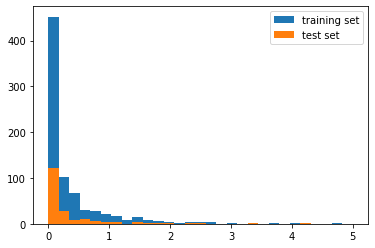

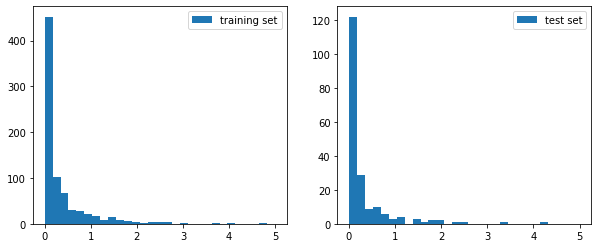

In [14]:
bins = np.linspace(0, 5, 30)

plt.hist(y_train, bins, label='training set')
plt.hist(y_test, bins, label='test set')
plt.legend(loc='upper right')
plt.show()
plt.close()


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(y_train, bins, label='training set')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(y_test, bins, label='test set')
plt.legend(loc='upper right')

plt.show()
plt.close()

In [15]:
for lds, fds in [(True,True),(True,False),(False,True),(False,False)]:
    set_seed()

    model = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
    model.fc.add_module('relu', nn.LeakyReLU())
    model = torch.nn.DataParallel(model, device_ids=[0, 1])
    model.cuda()

    wandb.init(project='20230214-validation',
               config={"model": "sfcn+lkrelu", "dropout": dropout_rate,
                       "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                       "cost_function": "mse_loss", "optimizer": optim_class.__name__,
                       "scheduler": sched_class.__name__, "lds": lds, "fds": fds})
    wandb.watch(model)

    optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = sched_class(optimizer, mode='min', patience=5, min_lr=0)

    best_mae, best_mse, best_p, best_s = 100, 100, 0, 0

    set_seed()
    for epoch in range(epochs):
        print('# Epoch %d / %d'%(epoch + 1, epochs))   

        # train set
        augment = get_augmentation_transform()
        train_set = NeckDataset(X_train, y_train, transform=augment, lds=lds)
        train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

        # validation set

        preds_t, truths_t, mae_t, mse_t = train(model, train_loader, epoch, lr, weight_decay, optimizer, lds=lds, fds=fds)
        preds_v, truths_v, mae_v, mse_v = valid(model, test_loader)

        scheduler.step(mse_v)
        last_lr = scheduler._last_lr[0]

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(test_loader)
        valid_mse = mse_v / len(test_loader)

        if best_mse > valid_mse:
            best_mse = valid_mse
            torch.save(model.state_dict(), 'pretrained/230304_sfcnlkrelu+mse_{}_lds{}fds{}_bestmse'.format(sched_class.__name__, lds, fds))
        if best_mae > valid_mae:
            best_mae = valid_mae
            torch.save(model.state_dict(), 'pretrained/230304_sfcnlkrelu+mse_{}_lds{}fds{}_bestmae'.format(sched_class.__name__, lds, fds))
        if best_p < valid_p:
            best_p = valid_p
        if best_s < valid_s:
            best_s = valid_s

        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
                   "lr": last_lr})
    wandb.finish()
    torch.save(model.state_dict(), 'pretrained/230304_sfcnlkrelu+mse_{}_lds{}fds{}_epochs{}'.format(sched_class.__name__, lds, fds, epochs))


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


# Epoch 1 / 150


  0%|                                                    | 0/49 [00:00<?, ?it/s]/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 2 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 3 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 4 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.07it/s]


# Epoch 5 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 6 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 7 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 8 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 9 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 10 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 11 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.98it/s]


# Epoch 12 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 13 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.50it/s]


# Epoch 14 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 15 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 16 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


# Epoch 17 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 18 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.28it/s]


# Epoch 19 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 20 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 21 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 22 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 23 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 24 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 25 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 26 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 27 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 28 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 29 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]


# Epoch 30 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.94it/s]


# Epoch 31 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.46it/s]


# Epoch 32 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 33 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 34 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 35 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 36 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 37 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


# Epoch 38 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 39 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 40 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 41 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 42 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 43 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 44 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 45 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.47it/s]


# Epoch 46 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.04it/s]


# Epoch 47 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 48 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 49 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 50 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 51 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 52 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 53 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


# Epoch 54 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.10it/s]


# Epoch 55 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 56 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 57 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.94it/s]


# Epoch 58 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


# Epoch 59 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 60 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 61 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 62 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.02it/s]


# Epoch 63 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.04it/s]


# Epoch 64 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 65 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 66 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


# Epoch 67 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


# Epoch 68 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 69 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


# Epoch 70 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 71 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


# Epoch 72 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 73 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 74 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 75 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.34it/s]


# Epoch 76 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 77 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.00it/s]


# Epoch 78 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 79 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 80 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 81 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 82 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.03it/s]


# Epoch 83 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


# Epoch 84 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


# Epoch 85 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.49it/s]


# Epoch 86 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 87 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 88 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.10it/s]


# Epoch 89 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 90 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 91 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 92 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 93 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 94 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 95 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.00it/s]


# Epoch 96 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.29it/s]


# Epoch 97 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 98 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


# Epoch 99 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 100 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 101 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 102 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]


# Epoch 103 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 104 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 105 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 106 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.01it/s]


# Epoch 107 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 108 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 109 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 110 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 111 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 112 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 113 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 114 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 115 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.12it/s]


# Epoch 116 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


# Epoch 117 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 118 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.99it/s]


# Epoch 119 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 120 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


# Epoch 121 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 122 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


# Epoch 123 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 124 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 125 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.01it/s]


# Epoch 126 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.06it/s]


# Epoch 127 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 128 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.94it/s]


# Epoch 129 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.92it/s]


# Epoch 130 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 131 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 132 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


# Epoch 133 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.04it/s]


# Epoch 134 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 135 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.01it/s]


# Epoch 136 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 137 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.97it/s]


# Epoch 138 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 139 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 140 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.06it/s]


# Epoch 141 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.12it/s]


# Epoch 142 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.93it/s]


# Epoch 143 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 144 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 145 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.05it/s]


# Epoch 146 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.02it/s]


# Epoch 147 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 148 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.92it/s]


# Epoch 149 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 150 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.09it/s]


lr,██████▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,▇█▆▄▄▅▄▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▂▁▂▂▁▁▁▂▁▁▂▁▂▁▁
train_mse,█▇▅▆▃▅▃▂▁▂▁▂▃▂▂▂▁▂▁▁▁▃▁▁▁▂▂▃▁▃▁▂▂▂▃▂▁▂▂▂
train_pearson,▃▁▄▄▆▄▅▄▆▇▆▇▅▇▆▆▆▇▇▇█▆▇█▇▇▇▅▆▅▇▆▆▆█▆▇▆▆▇
train_spearman,▅▂▅▄▆▅▆▁▂▅▃▆▅▇▇█▅▇█▆█▇▅▇▆▅▅▆▅▅▅▅▆▅▆▅▅▅▅▆
valid_mae,▆█▄▆▂▆▄▂▁▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂
valid_mse,▅█▄▆▂▆▅▃▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
valid_pearson,▄▁▅▃█▄▄▄▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
valid_spearman,█▁█▄▇▃▃▂▁▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄
lr,0.0
train_mae,1.16405


# Epoch 1 / 150


  0%|                                                    | 0/49 [00:00<?, ?it/s]/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 2 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


# Epoch 3 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.05it/s]


# Epoch 4 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


# Epoch 5 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.46it/s]


# Epoch 6 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 7 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 8 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


# Epoch 9 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 10 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 11 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


# Epoch 12 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 13 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.93it/s]


# Epoch 14 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 15 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.03it/s]


# Epoch 16 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.94it/s]


# Epoch 17 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 18 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 19 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.19it/s]


# Epoch 20 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 21 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


# Epoch 22 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.18it/s]


# Epoch 23 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.02it/s]


# Epoch 24 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 25 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 26 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.29it/s]


# Epoch 27 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


# Epoch 28 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.00it/s]


# Epoch 29 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 30 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 31 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


# Epoch 32 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 33 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


# Epoch 34 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 35 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 36 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


# Epoch 37 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 38 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.91it/s]


# Epoch 39 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 40 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.92it/s]


# Epoch 41 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 42 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.07it/s]


# Epoch 43 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


# Epoch 44 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 45 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.97it/s]


# Epoch 46 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 47 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 48 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


# Epoch 49 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 50 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 51 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.98it/s]


# Epoch 52 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.00it/s]


# Epoch 53 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.47it/s]


# Epoch 54 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.00it/s]


# Epoch 55 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.06it/s]


# Epoch 56 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.44it/s]


# Epoch 57 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.29it/s]


# Epoch 58 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


# Epoch 59 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 60 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


# Epoch 61 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 62 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.91it/s]


# Epoch 63 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


# Epoch 64 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 65 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 66 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


# Epoch 67 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 68 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.91it/s]


# Epoch 69 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 70 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 71 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.03it/s]


# Epoch 72 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 73 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 74 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 75 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 76 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


# Epoch 77 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 78 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.97it/s]


# Epoch 79 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.87it/s]


# Epoch 80 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 81 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


# Epoch 82 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 83 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.44it/s]


# Epoch 84 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


# Epoch 85 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 86 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 87 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]


# Epoch 88 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 89 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 90 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 91 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


# Epoch 92 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 93 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 94 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.47it/s]


# Epoch 95 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 96 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 97 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 98 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 99 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.93it/s]


# Epoch 100 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 101 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


# Epoch 102 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 103 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.15it/s]


# Epoch 104 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.49it/s]


# Epoch 105 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 106 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.09it/s]


# Epoch 107 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.28it/s]


# Epoch 108 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


# Epoch 109 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


# Epoch 110 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 111 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 112 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 113 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 114 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


# Epoch 115 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 116 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 117 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


# Epoch 118 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 119 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


# Epoch 120 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 121 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.93it/s]


# Epoch 122 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 123 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 124 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 125 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.09it/s]


# Epoch 126 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 127 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.16it/s]


# Epoch 128 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 129 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


# Epoch 130 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.89it/s]


# Epoch 131 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


# Epoch 132 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 133 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 134 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 135 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.04it/s]


# Epoch 136 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.05it/s]


# Epoch 137 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 138 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


# Epoch 139 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


# Epoch 140 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 141 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 142 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.06it/s]


# Epoch 143 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 144 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 145 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 146 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 147 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


# Epoch 148 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.22it/s]


# Epoch 149 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 150 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.48it/s]


lr,█████▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,▇██▆▅▃▃▂▂▁▂▂▂▂▂▂▂▂▂▂▁▃▂▂▂▃▂▁▂▁▁▁▂▂▂▂▂▂▂▁
train_mse,▅█▇▅▇▇▁▃▃▂▃▃▄▃▂▂▄▂▂▂▃▄▂▁▃▃▃▅▃▃▃▃▅▄▃▂▄▅▂▂
train_pearson,▄▁▄▂▂▃▆▆▄▅▄▃▂▅▅▅▄▅▄▇▇▆▅▅▄▄▇▆▅▅▅▆▃▆▄▅▅▄▆█
train_spearman,▇▂█▁▄▄▃▃▂▃▄▃▂▃▄▃▄▄▃▅▅▄▄▃▃▄▆▆▁▂▅▅▃▅▄▃▁▃▅▅
valid_mae,▁▆▃█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_mse,▁▆▃█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_pearson,▂▇▇▁▁▇██████████████████████████████████
valid_spearman,▃█▇▁▁▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▄▄▄▄▄▄▄▄▄▄▄▄▄
lr,0.0
train_mae,1.40422


# Epoch 1 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 2 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 3 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


# Epoch 4 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 5 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 6 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 7 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 8 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 9 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 10 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 11 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 12 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


# Epoch 13 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]


# Epoch 14 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 15 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 16 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


# Epoch 17 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 18 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 19 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 20 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


# Epoch 21 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 22 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


# Epoch 23 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 24 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 25 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 26 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 27 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 28 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 29 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 30 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 31 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 32 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 33 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.67it/s]


# Epoch 34 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 35 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 36 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 37 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 38 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.49it/s]


# Epoch 39 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


# Epoch 40 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.50it/s]


# Epoch 41 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 42 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 43 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.29it/s]


# Epoch 44 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


# Epoch 45 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.48it/s]


# Epoch 46 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 47 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 48 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s]


# Epoch 49 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 50 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 51 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 52 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 53 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 54 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


# Epoch 55 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 56 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 57 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


# Epoch 58 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.49it/s]


# Epoch 59 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


# Epoch 60 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 61 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 62 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 63 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


# Epoch 64 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


# Epoch 65 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.31it/s]


# Epoch 66 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 67 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 68 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 69 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


# Epoch 70 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


# Epoch 71 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.49it/s]


# Epoch 72 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]


# Epoch 73 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


# Epoch 74 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


# Epoch 75 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


# Epoch 76 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 77 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 78 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


# Epoch 79 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 80 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


# Epoch 81 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 82 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 83 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 84 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.28it/s]


# Epoch 85 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.24it/s]


# Epoch 86 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 87 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


# Epoch 88 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 89 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 90 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 91 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 92 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 93 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.49it/s]


# Epoch 94 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


# Epoch 95 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]


# Epoch 96 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 97 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.36it/s]


# Epoch 98 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 99 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.33it/s]


# Epoch 100 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 101 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 102 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.48it/s]


# Epoch 103 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.34it/s]


# Epoch 104 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 105 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 106 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 107 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s]


# Epoch 108 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 109 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 110 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 111 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.44it/s]


# Epoch 112 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 113 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 114 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 115 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 116 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 117 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


# Epoch 118 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 119 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 120 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.46it/s]


# Epoch 121 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 122 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 123 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.58it/s]


# Epoch 124 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 125 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 126 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 127 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 128 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


# Epoch 129 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 130 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.44it/s]


# Epoch 131 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.23it/s]


# Epoch 132 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 133 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 134 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.96it/s]


# Epoch 135 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 136 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 137 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 138 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 139 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.92it/s]


# Epoch 140 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 141 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 142 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.48it/s]


# Epoch 143 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.50it/s]


# Epoch 144 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 145 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 146 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 147 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 148 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


# Epoch 149 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.30it/s]


# Epoch 150 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


lr,█████▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▆▅▅▅▄▃▂▂▃▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▁▂▁▂▂▁
train_mse,█▆▅▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▁▂▂▂▂▂▁▂▂▂▁▂▂▂▁▁
train_pearson,▁▂▄▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇█▇█▇███▇▇▇▇███▇▇█▇▇▇██
train_spearman,▁▃▅▆▆▆▇▇▇▇█▇█▇▇█▇▇███▇▇█▇▇▇████▇█▇▇██▇██
valid_mae,▁▅▃█▃▅▆▇▇▇▆▅▆▅▅▆▅▄▅▅▅▅▅▅▅▅▅▄▅▄▄▄▅▄▄▄▅▄▄▄
valid_mse,█▇▅▃▃▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁
valid_pearson,▂▁▅▆▆▆▇▇▇███████████████████████████████
valid_spearman,▁▂▅▆▅▇▇█▇███▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
lr,0.0
train_mae,0.27498


# Epoch 1 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.51it/s]


# Epoch 2 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 3 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 4 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.26it/s]


# Epoch 5 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


# Epoch 6 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 7 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


# Epoch 8 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 9 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 10 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.48it/s]


# Epoch 11 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 12 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 13 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


# Epoch 14 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 15 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.33it/s]


# Epoch 16 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


# Epoch 17 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


# Epoch 18 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


# Epoch 19 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 20 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 21 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s]


# Epoch 22 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


# Epoch 23 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 24 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 25 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


# Epoch 26 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 27 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 28 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 29 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.39it/s]


# Epoch 30 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


# Epoch 31 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 32 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


# Epoch 33 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.74it/s]


# Epoch 34 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.49it/s]


# Epoch 35 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


# Epoch 36 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.87it/s]


# Epoch 37 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


# Epoch 38 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 39 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


# Epoch 40 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.91it/s]


# Epoch 41 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 42 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 43 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 44 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 45 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


# Epoch 46 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


# Epoch 47 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


# Epoch 48 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 49 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 50 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.77it/s]


# Epoch 51 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.34it/s]


# Epoch 52 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.47it/s]


# Epoch 53 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


# Epoch 54 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 55 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


# Epoch 56 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.64it/s]


# Epoch 57 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.83it/s]


# Epoch 58 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 59 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.26it/s]


# Epoch 60 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


# Epoch 61 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 62 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


# Epoch 63 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.28it/s]


# Epoch 64 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


# Epoch 65 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.46it/s]


# Epoch 66 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 67 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 68 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


# Epoch 69 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.35it/s]


# Epoch 70 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 71 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 72 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 73 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 74 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.48it/s]


# Epoch 75 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.29it/s]


# Epoch 76 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


# Epoch 77 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


# Epoch 78 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 79 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 80 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


# Epoch 81 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.46it/s]


# Epoch 82 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.86it/s]


# Epoch 83 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


# Epoch 84 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 85 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.90it/s]


# Epoch 86 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.65it/s]


# Epoch 87 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.46it/s]


# Epoch 88 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


# Epoch 89 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.52it/s]


# Epoch 90 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 91 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.70it/s]


# Epoch 92 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.33it/s]


# Epoch 93 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 94 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 95 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.09it/s]


# Epoch 96 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.73it/s]


# Epoch 97 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.81it/s]


# Epoch 98 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 99 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.75it/s]


# Epoch 100 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.42it/s]


# Epoch 101 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.50it/s]


# Epoch 102 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.45it/s]


# Epoch 103 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.50it/s]


# Epoch 104 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 105 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 106 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.85it/s]


# Epoch 107 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 108 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.37it/s]


# Epoch 109 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


# Epoch 110 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


# Epoch 111 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


# Epoch 112 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 113 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.49it/s]


# Epoch 114 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 115 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.27it/s]


# Epoch 116 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.76it/s]


# Epoch 117 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 118 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.44it/s]


# Epoch 119 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.38it/s]


# Epoch 120 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 121 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 122 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.72it/s]


# Epoch 123 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


# Epoch 124 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 125 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 126 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.79it/s]


# Epoch 127 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


# Epoch 128 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.80it/s]


# Epoch 129 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.66it/s]


# Epoch 130 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.40it/s]


# Epoch 131 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.82it/s]


# Epoch 132 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.56it/s]


# Epoch 133 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 134 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 135 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.55it/s]


# Epoch 136 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.41it/s]


# Epoch 137 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.19it/s]


# Epoch 138 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 139 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.57it/s]


# Epoch 140 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.61it/s]


# Epoch 141 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.84it/s]


# Epoch 142 / 150


100%|███████████████████████████████████████████| 13/13 [00:03<00:00,  4.28it/s]


# Epoch 143 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.54it/s]


# Epoch 144 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.60it/s]


# Epoch 145 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


# Epoch 146 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.62it/s]


# Epoch 147 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


# Epoch 148 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.71it/s]


# Epoch 149 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.46it/s]


# Epoch 150 / 150


100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.43it/s]


lr,████▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_mae,█▆▆▅▄▃▃▃▃▂▃▂▂▂▁▂▂▂▂▂▁▁▂▂▂▂▁▂▂▂▁▂▂▁▁▁▂▁▁▁
train_mse,█▆▅▅▄▃▃▃▃▂▃▂▂▂▁▂▂▂▂▂▁▂▂▂▂▂▁▂▂▂▁▂▂▂▁▁▁▂▁▁
train_pearson,▁▃▄▄▅▆▆▆▆▇▆▇▇▇██▇▇▇▇██▇▇▇▇█▇▇▇█▇▇▇███▇██
train_spearman,▁▃▅▅▆▇▆▇▇▇▇▇██▇██▇█▇████▇▇██▇▇█▇▇█▇█▇███
valid_mae,▃▅▂█▂▄▃▂▅▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
valid_mse,█▃▃▅▂▂▂▁▃▁▃▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_pearson,▁▃▄▄▅▅▆▇▆██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
valid_spearman,▁▃▅▇▇█▇█▇██▇▇▆▇▇▇▇▇▆▇▇▇▇▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇
lr,0.0
train_mae,0.27969


In [16]:
import seaborn as sns

def predict(model, data_loader, title='', line=False):
    model.eval()
    preds, truths = np.array([]), np.array([])
    with torch.no_grad():
        for inputs, labels, _ in tqdm(data_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            output = model(inputs)
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)
        
    # Get correlation coefficients
    pearson, pearson_p = pearsonr(preds, truths)
    spearman, spearman_p = spearmanr(preds, truths)
    
    # For range setting
    _min = y_min
    _max = y_max
    
    # Figure size
#     plt.figure(figsize=(5, 5))
    
    # Reference line
    x = np.linspace(_min, _max)
    y = x
    plt.plot(x, y, c='gray', ls='--', label='Reference r = 1.0')
    
    # Regression Plot
    
    ## Scatter
    plt.scatter(truths, preds, c='steelblue', label='Pearson\'s r = {:.2f} / Spearman\'s r = {:.2f}'.format(pearson,spearman))
    
    ## Linear Regression Line
    if line:
        m, b = np.polyfit(truths, preds, 1)
        plt.plot(truths, m*truths + b, c='steelblue', label='m = {:.2f}'.format(m))
#     # Regression Plot at once
#     sns.regplot(x=truths, y=preds, ci=None, color='steelblue', label='Pearson r = {:.2f}'.format(pearson))

    if title != '':
        plt.title(title)
    
    plt.axis('square')
    plt.ylabel('Predicted WMH'); plt.xlabel('Ground Truth')
    plt.legend()
    plt.tight_layout()
    plt.xlim([_min, _max])
    plt.ylim([_min, _max])
    plt.show()
    plt.close()
    
    return preds, truths

In [17]:
y_min, y_max =y_test.min()-0.5, y_test.max()+0.5
y_min, y_max

(-0.5, 4.701782967868128)

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.63it/s]


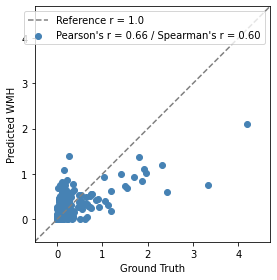

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.69it/s]


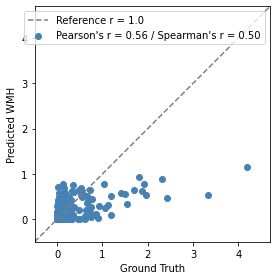

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.05it/s]


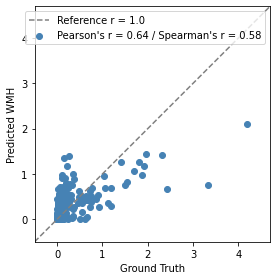

In [22]:
fds = True

# FDS net, best MSE
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsFalsefds{}_bestmse'.format(sched_class.__name__, fds)))
net.cuda()
_,_ = predict(net, test_loader)

# FDS net, best MAE
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsFalsefds{}_bestmae'.format(sched_class.__name__, fds)))
net.cuda()
_,_ = predict(net, test_loader)

# FDS net, epoch 150
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsFalsefds{}_epochs{}'.format(sched_class.__name__, fds, epochs)))
net.cuda()
_,_ = predict(net, test_loader)

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.59it/s]


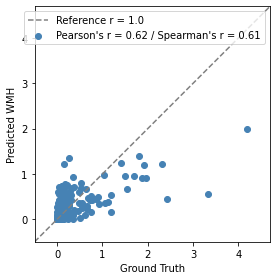

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.53it/s]


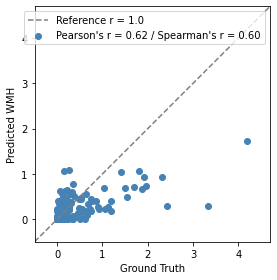

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.68it/s]


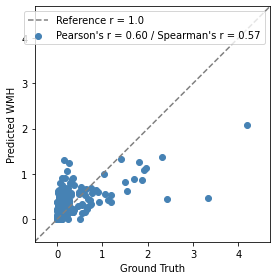

In [23]:
fds = False

# original net, best MSE
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsFalsefds{}_bestmse'.format(sched_class.__name__, fds)))
net.cuda()
_,_ = predict(net, test_loader)

# original net, best MAE
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsFalsefds{}_bestmae'.format(sched_class.__name__, fds)))
net.cuda()
_,_ = predict(net, test_loader)

# original net, epoch 150
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsFalsefds{}_epochs{}'.format(sched_class.__name__, fds, epochs)))
net.cuda()
_,_ = predict(net, test_loader)

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.78it/s]


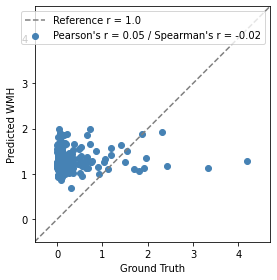

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.92it/s]


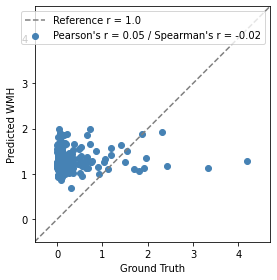

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.01it/s]


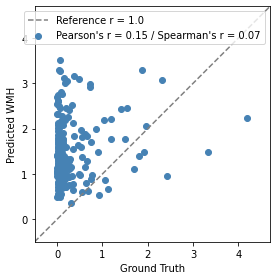

In [24]:
lds = True
fds = False

# original net, best MSE
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsTruefds{}_bestmse'.format(sched_class.__name__, fds)))
net.cuda()
_,_ = predict(net, test_loader)

# original net, best MAE
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsTruefds{}_bestmae'.format(sched_class.__name__, fds)))
net.cuda()
_,_ = predict(net, test_loader)

# original net, epoch 150
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsTruefds{}_epochs{}'.format(sched_class.__name__, fds, epochs)))
net.cuda()
_,_ = predict(net, test_loader)

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.06it/s]


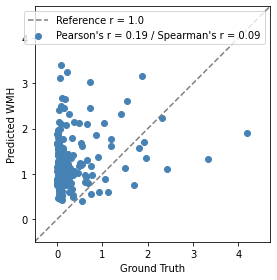

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.10it/s]


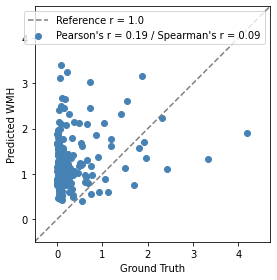

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  4.88it/s]


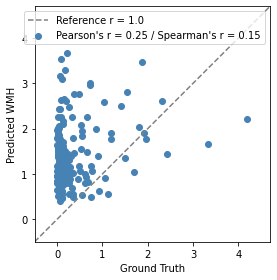

In [25]:
lds = True
fds = True

# original net, best MSE
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsTruefds{}_bestmse'.format(sched_class.__name__, fds)))
net.cuda()
_,_ = predict(net, test_loader)

# original net, best MAE
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsTruefds{}_bestmae'.format(sched_class.__name__, fds)))
net.cuda()
_,_ = predict(net, test_loader)

# original net, epoch 150
net = SFCN_FDS(dropout_p=dropout_rate, fds=fds)
net.fc.add_module('relu', nn.LeakyReLU())
net = torch.nn.DataParallel(net, device_ids=[0, 1])
net.load_state_dict(torch.load('pretrained/230304_sfcnlkrelu+mse_{}_ldsTruefds{}_epochs{}'.format(sched_class.__name__, fds, epochs)))
net.cuda()
_,_ = predict(net, test_loader)

In [ ]:
net = SFCN()
net.load_state_dict(torch.load('pretrained/230228_sfcn+mse_ReduceLROnPlateau_bestmse'))
# net.to(device)
# _,_ = predict(net, test_loader)

In [ ]:
dataset = NeckDataset(train_X, train_y)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16)
_,_ = predict(model, train_loader, 'Training set')